### Exploratory Data Analysis

In [26]:
import pandas as pd
import ast
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.pyplot
import seaborn as sns

#### Importing data

In [30]:
# Read in TMDB movie data
tmdb_data = pd.read_csv(f'../data/movies_2015_2024.csv').drop_duplicates(subset=['Title','Year'])

# Import best picture data
best_picture = pd.read_csv('../data/best_picture.csv')

In [31]:
# Merge best picture data and TMDB API data into a single DataFrame
movies_df = best_picture.merge(tmdb_data, how='right', on=['Title','Year'], validate='1:1')

# Fill NaN values 
values = {'Winner': 'No', 'Nominated': 'No'}
movies_df = movies_df.fillna(value=values)

#### Research question: convert budget and revenue data to 2024 dollars using CPI data

In [32]:
# Store CPI values 
cpi_data = pd.read_csv('../data/CPI_data.csv').set_index('Year')

In [33]:
budget_2024 = []
for year,budget in zip(movies_df['Year'], movies_df['Budget']):
    budget_adjusted = budget*(cpi_data.loc[2024,'CPI'] / cpi_data.loc[year,'CPI'])
    budget_2024.append(budget_adjusted)

# Reassign adjusted budget numbers to the Budget column
movies_df['Budget'] = budget_2024

In [34]:
revenue_2024 = []
for year,revenue in zip(movies_df['Year'], movies_df['Revenue']):
    revenue_adjusted = revenue*(cpi_data.loc[2024,'CPI'] / cpi_data.loc[year,'CPI'])
    revenue_2024.append(revenue_adjusted)

# Reassign adjusted budget numbers to the Revenue column
movies_df['Revenue'] = revenue_2024

In [35]:
# Rename the Budget and Revenue columns to reflect the conversion to 2024 dollars
movies_df = movies_df.rename(columns={'Budget': 'Budget (2024 dollars)', 'Revenue': 'Revenue (2024 dollars)'})

#### Research question: How popular is each genre over the last decade?

##### Attempt #1: Creating a linear model for vote average based on year and genre

In [45]:
# Convert Genre column to list type so that it can be exploded
movies_df['Genre'] = movies_df['Genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)

In [38]:
# Explode the movies_df DataFrame by genre
movies_df_exploded = movies_df.explode('Genre')

In [39]:
# Create an indicator variable for each genre
genre_dummies = pd.get_dummies(movies_df_exploded['Genre'], prefix='genre')

In [40]:
# Group the genre indicator variables so that we have 1 row per movie
genre_dummies_grouped = genre_dummies.groupby(level=0).max()

# Replace spaces in column names with underscores
genre_dummies_grouped.columns = [column.replace(' ','_') for column in genre_dummies_grouped.columns]

In [41]:
# Join the genre indicator variables to the movies_df DataFrame
movies_genre_indicator = movies_df.join(genre_dummies_grouped)

In [42]:
# Fitting a linear regression model for vote_average using years and each of the genre indicator variables

# Extract all of the genre indicator variables and concatenate them with plus signs to be used in the linear model
genre_indicators = [column for column in movies_genre_indicator.columns if 'genre_' in column]
genre_indicators = ' + '.join(genre_indicators)

popularity_model_with_genres = smf.ols(f'Vote_Average ~ Year + {genre_indicators}', data = movies_genre_indicator).fit()
popularity_model_with_genres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Vote_Average   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     14.53
Date:                Tue, 18 Nov 2025   Prob (F-statistic):           4.62e-43
Time:                        20:54:30   Log-Likelihood:                -868.55
No. Observations:                1005   AIC:                             1779.
Df Residuals:                     984   BIC:                             1882.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -51.0257     13.010     -3.922      0.000     -76.557     -25.495
genre_Action[T.True]             -0.0564      0.052     -1.083      0.279      -0.159       0.046
genre_Adventure[T.True]           0.0357      0.054      0.658      0.510      -0.071       0.142
genre_Animation[T.True]           0.6238      0.084      7.433      0.000       0.459       0.789
genre_Comedy[T.True]             -0.1015      0.050     -2.025      0.043      -0.200      -0.003
genre_Crime[T.True]              -0.0382      0.060     -0.634      0.526      -0.156       0.080
genre_Documentary[T.True]         0.3735      0.341      1.096      0.273      -0.295       1.042
genre_Drama[T.True]               0.2760      0.054      5.107      0.000       0.170       0.382
genre_Family[T.True]             -0.1276      0.085     -1.501      0.134      -0.294       0.039
genre_Fantasy[T.True]            -0.1571      0.058     -2.700      0.007      -0.271      -0.043
genre_History[T.True]             0.1210      0.085      1.423      0.155      -0.046       0.288
genre_Horror[T.True]             -0.3124      0.063     -4.939      0.000      -0.437      -0.188
genre_Music[T.True]               0.0791      0.115      0.688      0.492      -0.147       0.305
genre_Mystery[T.True]            -0.0598      0.067     -0.898      0.370      -0.191       0.071
genre_Romance[T.True]             0.0557      0.064      0.871      0.384      -0.070       0.181
genre_Science_Fiction[T.True]    -0.1076      0.055     -1.970      0.049      -0.215      -0.000
genre_TV_Movie[T.True]            0.6443      0.418      1.541      0.124      -0.176       1.465
genre_Thriller[T.True]           -0.1143      0.050     -2.272      0.023      -0.213      -0.016
genre_War[T.True]                 0.1056      0.126      0.839      0.402      -0.141       0.353
genre_Western[T.True]             0.0197      0.198      0.099      0.921      -0.369       0.408
Year                              0.0287      0.006      4.454      0.000       0.016       0.041
==============================================================================
Omnibus:                       23.749   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.361
Skew:                          -0.348   Prob(JB):                     3.11e-06
Kurtosis:                       3.346   Cond. No.                     1.44e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Attempt #2: Bar chart plotting vote average by genre

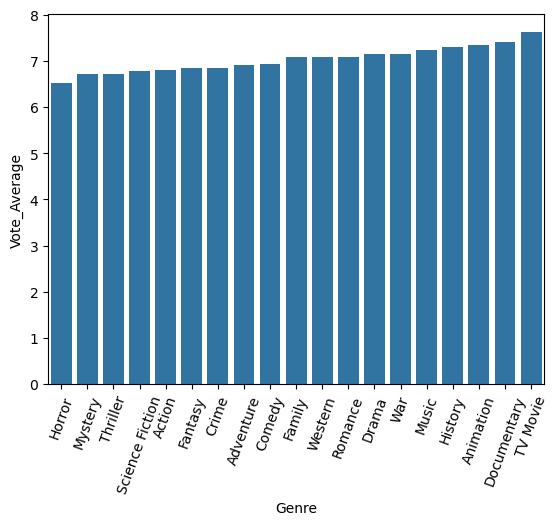

In [43]:
# Creating bar chart to show average vote count by genre
avg_vote_by_genre = movies_df_exploded.groupby('Genre').agg({'Vote_Average': 'mean'}).sort_values(by='Vote_Average')
sns.barplot(data=avg_vote_by_genre, x='Genre', y='Vote_Average')
plt.xticks(rotation=70) 
plt.show()

##### Attempt #3: Evaluating popularity by average revenue 

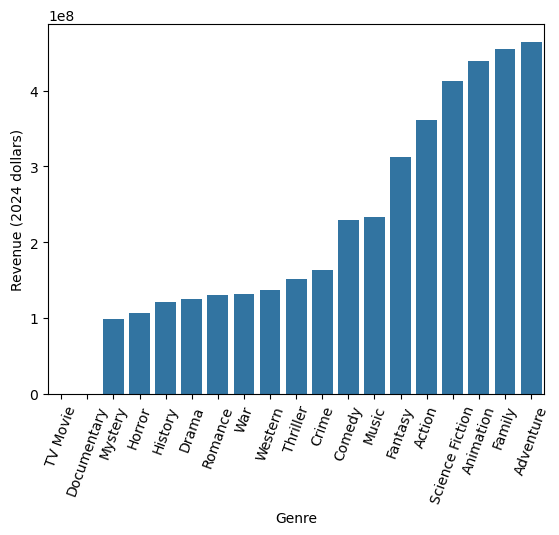

In [46]:
# Creating bar chart to show average revenue by genre
avg_vote_by_genre = movies_df_exploded.groupby('Genre').agg({'Revenue (2024 dollars)': 'mean'}).sort_values(by='Revenue (2024 dollars)')
sns.barplot(data=avg_vote_by_genre, x='Genre', y='Revenue (2024 dollars)')
plt.xticks(rotation=70) 
plt.show()

##### Attempt #4: Evaluating popularity by number of movies that were in the top 10 highest earning movies in that year